
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # End of episodes/goal/task where nextQs = 0 and Qs=rs
    dones = tf.placeholder(tf.bool, [None], name='dones') # masked

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    nextQs_D = tf.placeholder(tf.float32, [None], name='nextQs_D') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, dones, nextQs, nextQs_D

In [7]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [20]:
# The model loss for predicted/generated actions
def model_loss(prev_actions, states, actions, # model input data for Qs/qs/rs 
               nextQs, gamma, # model input data for targetQs
               state_size, action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, _ = generator(prev_actions=prev_actions_onehot, states=states, 
                                  hidden_size=hidden_size, state_size=state_size, action_size=action_size)
    
    # Masking actions_logits unmasked
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    #     # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    #     qs = tf.sigmoid(Qs) # qt
    #     targetQs = qs + (gamma * nextQs)

    #     # Calculating the loss: logits/predictions vs labels
    #     q_loss = tf.reduce_mean(tf.square(Qs - targetQs))
    q_loss = tf.reduce_mean(tf.square(Qs - nextQs))

    return actions_logits, q_loss

In [21]:
# Outputing the unmasked nextQs for D to be used as the target/label
def model_output(actions, next_states,
                 action_size, hidden_size):
    # Discriminator for nextQs_D
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_D_unmasked = discriminator(prev_actions=actions_onehot, states=next_states, hidden_size=hidden_size)
    
    # Returning unmasked nextQs_D to masked using dones/ends of episodes
    return nextQs_D_unmasked

In [22]:
# The model loss for the NEW idea G & D
def model_loss2(nextQs_D, gamma, 
                prev_actions, states, 
                action_size, hidden_size):
    # Calculating Qs total rewards using Discriminator
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    Qs = discriminator(prev_actions=prev_actions_onehot, states=states, hidden_size=hidden_size, reuse=True)
        
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_D = qs + (gamma * nextQs_D)
    
    # Calculating the loss: logits/predictions vs labels
    #d_loss = tf.reduce_mean(tf.square(Qs - targetQs_D))
    d_loss = tf.reduce_mean(tf.square(Qs - nextQs_D))
    
    # Returning the D loss
    return d_loss

In [23]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss3(nextQs_D, gamma,
                prev_actions, states, dones, 
                state_size, action_size, hidden_size):
    # Generator for nextQs_G
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_G
    nextQs_G_unmasked = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                      hidden_size=hidden_size, reuse=True)
    
    # Masking the unmasked nextQs_G using dones/end of episodes/goal
    dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=nextQs_G_unmasked.dtype, x=dones)), shape=[-1, 1])
    nextQs_G_masked = tf.multiply(nextQs_G_unmasked, dones_mask)
    nextQs_G = tf.reduce_max(axis=1, input_tensor=nextQs_G_masked)

    # Below is the idea behind this loss
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_G = qs + (gamma * nextQs_G)
    # targetQs_D = qs + (gamma * nextQs_D)
    # targetQs_G = targetQs_D
    # nextQs_G = nextQs_D 
    # Calculating the loss: logits/predictions vs labels
    g_loss = tf.reduce_mean(tf.square(nextQs_G - nextQs_D))
    
    # Returning g_loss which should impact Generator
    return g_loss

In [24]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Generator loss for action prediction
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars) # action prediction
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # state prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return q_opt, g_opt, d_opt

In [25]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.dones, self.nextQs, self.nextQs_D = model_input(
            state_size=state_size)

        # Output of the Model
        self.nextQs_D_unmasked = model_output(actions=self.actions, next_states=self.next_states,
                                              action_size=action_size, hidden_size=hidden_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.q_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init parameters
            prev_actions=self.prev_actions, states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Loss of the model: reward prob/logits prediction
        self.d_loss = model_loss2(nextQs_D=self.nextQs_D, gamma=gamma,
                                  action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        # Loss of the model: states prediction/generation
        self.g_loss = model_loss3(nextQs_D=self.nextQs_D, gamma=gamma, dones=self.dones,
                                  state_size=state_size, action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, 
                                                       g_loss=self.g_loss, 
                                                       d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [26]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [27]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [28]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [29]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
             gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [30]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
#state, reward, done, info = env.step(prev_action) # St, Rt/Et (Epiosde)
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        
        # Print out reward and done and check if they are the same: They are NOT.
        #print('if done is true:', reward, done)
        
        # # the episode ends so no next state
        # next_state = np.zeros(state.shape)
                
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Print out reward and done and check if they are the same!
        #print('else done is false:', reward, done)
        
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [31]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, 
                       model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Masking for the end of episodes/ goals
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At, St+1)= Qt+1/nextQs_D/nextQs
            # Calculating nextQs for Discriminator using D(~At, ~St+1)= ~Qt+1/nextQs_G/nextQs2
            feed_dict={model.prev_actions: prev_actions, model.states: states,
                       model.actions: actions, model.next_states: next_states}
            nextQs_D_unmasked = sess.run(model.nextQs_D_unmasked, feed_dict)
            
            # Masking for the end of episodes/ goals
            dones_mask = (1 - dones.astype(nextQs_D_unmasked[0].dtype)).reshape(-1, 1)
            nextQs_D_masked = np.multiply(nextQs_D_unmasked[0], dones_mask)
            nextQs_D = np.max(nextQs_D_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # NextQs/Qt+1 are given both:
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.dones: dones,
                         model.nextQs: nextQs,
                         model.nextQs_D: nextQs_D}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 7 Training q_loss: 0.0139 Training g_loss: 0.0003 Training d_loss: 0.0004 Explore P: 0.9993
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 36 Training q_loss: 0.2553 Training g_loss: 0.0006 Training d_loss: 0.0001 Explore P: 0.9958
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 15 Training q_loss: 0.2534 Training g_loss: 0.0005 Training d_loss: 0.0001 Explore P: 0.9943
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 27 Training q_loss: 1.3069 Training g_loss: 0.0003 Training d_

-------------------------------------------------------------------------------
Episode: 30 Total reward: 51 Training q_loss: 12.3490 Training g_loss: 0.6861 Training d_loss: 0.0001 Explore P: 0.9315
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 31 Total reward: 15 Training q_loss: 3.8571 Training g_loss: 1.4708 Training d_loss: 0.0009 Explore P: 0.9301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 32 Total reward: 35 Training q_loss: 1.7526 Training g_loss: 0.0093 Training d_loss: 0.0001 Explore P: 0.9269
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 20 Training q_loss: 1.7497 Training g_loss: 0.0049 Train

-------------------------------------------------------------------------------
Episode: 60 Total reward: 26 Training q_loss: 10.8932 Training g_loss: 0.0294 Training d_loss: 0.0000 Explore P: 0.8590
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 61 Total reward: 24 Training q_loss: 17.7902 Training g_loss: 0.0552 Training d_loss: 0.0000 Explore P: 0.8569
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 62 Total reward: 18 Training q_loss: 20.5560 Training g_loss: 0.0145 Training d_loss: 0.0000 Explore P: 0.8554
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 63 Total reward: 35 Training q_loss: 34.5585 Training g_loss: 0.0452 Tr

-------------------------------------------------------------------------------
Episode: 90 Total reward: 24 Training q_loss: 61694.8203 Training g_loss: 88.1468 Training d_loss: 0.0000 Explore P: 0.7738
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 91 Total reward: 24 Training q_loss: 198849.9531 Training g_loss: 93.1160 Training d_loss: 0.0000 Explore P: 0.7720
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 92 Total reward: 15 Training q_loss: 212684.4062 Training g_loss: 350.6299 Training d_loss: 0.0000 Explore P: 0.7708
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 33 Training q_loss: 158378.4375 Trainin

-------------------------------------------------------------------------------
Episode: 119 Total reward: 34 Training q_loss: 14592105.0000 Training g_loss: 4384.0537 Training d_loss: 0.0000 Explore P: 0.6851
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 120 Total reward: 93 Training q_loss: 6347678.5000 Training g_loss: 1646.8143 Training d_loss: 0.0000 Explore P: 0.6789
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 121 Total reward: 38 Training q_loss: 13138473.0000 Training g_loss: 13734.3398 Training d_loss: 0.0000 Explore P: 0.6763
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 122 Total reward: 69 Training q_loss: 119

-------------------------------------------------------------------------------
Episode: 148 Total reward: 32 Training q_loss: 2826653952.0000 Training g_loss: 989659.6875 Training d_loss: 0.0000 Explore P: 0.5703
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 149 Total reward: 37 Training q_loss: 4038971136.0000 Training g_loss: 31919.5352 Training d_loss: 0.0000 Explore P: 0.5682
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 150 Total reward: 38 Training q_loss: 2785721344.0000 Training g_loss: 1206238.1250 Training d_loss: 0.0000 Explore P: 0.5661
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 151 Total reward: 199 Trainin

-------------------------------------------------------------------------------
Episode: 176 Total reward: 42 Training q_loss: 465052467200.0000 Training g_loss: 235859536.0000 Training d_loss: 0.0000 Explore P: 0.4101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total reward: 199 Training q_loss: 668823650304.0000 Training g_loss: 8571218.0000 Training d_loss: 0.0000 Explore P: 0.4023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 178 Total reward: 199 Training q_loss: 602144112640.0000 Training g_loss: 1199993.8750 Training d_loss: 0.0000 Explore P: 0.3945
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 179 Total reward

-------------------------------------------------------------------------------
Episode: 204 Total reward: 199 Training q_loss: 4456082046976.0000 Training g_loss: 20371664.0000 Training d_loss: 0.0000 Explore P: 0.2445
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 205 Total reward: 199 Training q_loss: 6323579125760.0000 Training g_loss: 106228384.0000 Training d_loss: 0.0000 Explore P: 0.2399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 206 Total reward: 199 Training q_loss: 2111209734144.0000 Training g_loss: 2290111232.0000 Training d_loss: 0.0000 Explore P: 0.2353
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 207 Tota

-------------------------------------------------------------------------------
Episode: 232 Total reward: 199 Training q_loss: 14441127084032.0000 Training g_loss: 45464592.0000 Training d_loss: 0.0000 Explore P: 0.1468
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 199 Training q_loss: 5411593256960.0000 Training g_loss: 3918911488.0000 Training d_loss: 0.0000 Explore P: 0.1441
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 199 Training q_loss: 11648587792384.0000 Training g_loss: 1884458240.0000 Training d_loss: 0.0000 Explore P: 0.1415
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 T

-------------------------------------------------------------------------------
Episode: 260 Total reward: 199 Training q_loss: 3032993497088.0000 Training g_loss: 169404864.0000 Training d_loss: 0.0000 Explore P: 0.0884
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 261 Total reward: 199 Training q_loss: 7669766160384.0000 Training g_loss: 492771520.0000 Training d_loss: 0.0000 Explore P: 0.0868
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 262 Total reward: 199 Training q_loss: 21053975822336.0000 Training g_loss: 271046080.0000 Training d_loss: 0.0000 Explore P: 0.0853
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 263 Tot

-------------------------------------------------------------------------------
Episode: 287 Total reward: 199 Training q_loss: 50684472852480.0000 Training g_loss: 46219145216.0000 Training d_loss: 0.0000 Explore P: 0.0559
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 288 Total reward: 199 Training q_loss: 50138571603968.0000 Training g_loss: 39746093056.0000 Training d_loss: 0.0000 Explore P: 0.0550
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 289 Total reward: 199 Training q_loss: 39767060250624.0000 Training g_loss: 36218511360.0000 Training d_loss: 0.0000 Explore P: 0.0541
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode:

-------------------------------------------------------------------------------
Episode: 315 Total reward: 199 Training q_loss: 142228982857728.0000 Training g_loss: 3812300.2500 Training d_loss: 0.0000 Explore P: 0.0365
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 316 Total reward: 199 Training q_loss: 130988868894720.0000 Training g_loss: 3520799.2500 Training d_loss: 0.0000 Explore P: 0.0360
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 317 Total reward: 199 Training q_loss: 301541399461888.0000 Training g_loss: 4157646.7500 Training d_loss: 0.0000 Explore P: 0.0355
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 318 Tota

-------------------------------------------------------------------------------
Episode: 343 Total reward: 199 Training q_loss: 423857571758080.0000 Training g_loss: 1921819392.0000 Training d_loss: 0.0000 Explore P: 0.0252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 344 Total reward: 199 Training q_loss: 294171906670592.0000 Training g_loss: 976487296.0000 Training d_loss: 0.0000 Explore P: 0.0249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 345 Total reward: 199 Training q_loss: 319055974105088.0000 Training g_loss: 803790848.0000 Training d_loss: 0.0000 Explore P: 0.0246
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3

-------------------------------------------------------------------------------
Episode: 371 Total reward: 199 Training q_loss: 632386891022336.0000 Training g_loss: 29803858.0000 Training d_loss: 0.0000 Explore P: 0.0187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 372 Total reward: 199 Training q_loss: 1234743102275584.0000 Training g_loss: 17991072.0000 Training d_loss: 0.0000 Explore P: 0.0185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 373 Total reward: 199 Training q_loss: 787108524457984.0000 Training g_loss: 17146068.0000 Training d_loss: 0.0000 Explore P: 0.0184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 374 

-------------------------------------------------------------------------------
Episode: 399 Total reward: 199 Training q_loss: 1756343526490112.0000 Training g_loss: 322089.0938 Training d_loss: 0.0000 Explore P: 0.0150
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 400 Total reward: 199 Training q_loss: 722004135116800.0000 Training g_loss: 27430.1133 Training d_loss: 0.0000 Explore P: 0.0149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 401 Total reward: 199 Training q_loss: 1836969994747904.0000 Training g_loss: 50432.4883 Training d_loss: 0.0000 Explore P: 0.0148
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 402 Total r

-------------------------------------------------------------------------------
Episode: 426 Total reward: 199 Training q_loss: 4680444805120.0000 Training g_loss: 8589182464.0000 Training d_loss: 0.0000 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 427 Total reward: 199 Training q_loss: 7442635161600.0000 Training g_loss: 9018231808.0000 Training d_loss: 0.0000 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 428 Total reward: 199 Training q_loss: 33862193250304.0000 Training g_loss: 44127977472.0000 Training d_loss: 0.0000 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 429

-------------------------------------------------------------------------------
Episode: 454 Total reward: 199 Training q_loss: 122028510150656.0000 Training g_loss: 1724766592.0000 Training d_loss: 0.0000 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 455 Total reward: 199 Training q_loss: 87999979192320.0000 Training g_loss: 1830481408.0000 Training d_loss: 0.0000 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 456 Total reward: 199 Training q_loss: 123358909825024.0000 Training g_loss: 1692045312.0000 Training d_loss: 0.0000 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 

-------------------------------------------------------------------------------
Episode: 482 Total reward: 199 Training q_loss: 5428313849856.0000 Training g_loss: 129761640.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 483 Total reward: 199 Training q_loss: 207955488145408.0000 Training g_loss: 4963169280.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 484 Total reward: 199 Training q_loss: 52022694903808.0000 Training g_loss: 378307584.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 485 

-------------------------------------------------------------------------------
Episode: 510 Total reward: 199 Training q_loss: 1490496459374592.0000 Training g_loss: 43937568.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 511 Total reward: 199 Training q_loss: 863063142039552.0000 Training g_loss: 42605968.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 512 Total reward: 199 Training q_loss: 1374816749748224.0000 Training g_loss: 44304892.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 513

-------------------------------------------------------------------------------
Episode: 538 Total reward: 199 Training q_loss: 3051612381642752.0000 Training g_loss: 19253056.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 539 Total reward: 199 Training q_loss: 2282965438562304.0000 Training g_loss: 10428371.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 540 Total reward: 199 Training q_loss: 1870328603082752.0000 Training g_loss: 7197083.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 541

-------------------------------------------------------------------------------
Episode: 566 Total reward: 199 Training q_loss: 367275135729664.0000 Training g_loss: 345324.8438 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 567 Total reward: 199 Training q_loss: 500092536619008.0000 Training g_loss: 376301.2500 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 568 Total reward: 199 Training q_loss: 1667587758882816.0000 Training g_loss: 802042.5000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 569 Total 

-------------------------------------------------------------------------------
Episode: 594 Total reward: 199 Training q_loss: 325148318105600.0000 Training g_loss: 192130784.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 595 Total reward: 199 Training q_loss: 375525130371072.0000 Training g_loss: 190981120.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 596 Total reward: 199 Training q_loss: 468943722512384.0000 Training g_loss: 160899408.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 59

-------------------------------------------------------------------------------
Episode: 622 Total reward: 199 Training q_loss: 3028344664752128.0000 Training g_loss: 8886428.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 623 Total reward: 199 Training q_loss: 3160633415565312.0000 Training g_loss: 2413755.7500 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 199 Training q_loss: 6129369302958080.0000 Training g_loss: 515379.1875 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 To

-------------------------------------------------------------------------------
Episode: 649 Total reward: 199 Training q_loss: 1164964781883392.0000 Training g_loss: 5949453312.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 650 Total reward: 199 Training q_loss: 2552122717503488.0000 Training g_loss: 4419414016.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 651 Total reward: 199 Training q_loss: 1242183327809536.0000 Training g_loss: 3673110016.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episo

-------------------------------------------------------------------------------
Episode: 676 Total reward: 8 Training q_loss: 50533255610368.0000 Training g_loss: 8956838912.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 677 Total reward: 7 Training q_loss: 45318955597824.0000 Training g_loss: 9819868160.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 678 Total reward: 8 Training q_loss: 309794715992064.0000 Training g_loss: 8911017984.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 679 Tot

-------------------------------------------------------------------------------
Episode: 705 Total reward: 8 Training q_loss: 321439748063232.0000 Training g_loss: 5606461952.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 706 Total reward: 11 Training q_loss: 48449114341376.0000 Training g_loss: 6155715072.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 707 Total reward: 9 Training q_loss: 44032365428736.0000 Training g_loss: 6484191232.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 708 To

-------------------------------------------------------------------------------
Episode: 733 Total reward: 9 Training q_loss: 1018841605865472.0000 Training g_loss: 4575965184.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 734 Total reward: 8 Training q_loss: 769987308421120.0000 Training g_loss: 4244010752.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 735 Total reward: 7 Training q_loss: 54669636272128.0000 Training g_loss: 8065847808.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 736 T

-------------------------------------------------------------------------------
Episode: 761 Total reward: 11 Training q_loss: 69028898930688.0000 Training g_loss: 8681432064.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 762 Total reward: 9 Training q_loss: 1043691682660352.0000 Training g_loss: 1903051136.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 763 Total reward: 11 Training q_loss: 925828250599424.0000 Training g_loss: 1570189184.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 764

-------------------------------------------------------------------------------
Episode: 790 Total reward: 10 Training q_loss: 1251174841843712.0000 Training g_loss: 1614491264.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 791 Total reward: 10 Training q_loss: 60305417699328.0000 Training g_loss: 929238848.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 792 Total reward: 11 Training q_loss: 1404051921043456.0000 Training g_loss: 1158813184.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 79

-------------------------------------------------------------------------------
Episode: 818 Total reward: 64 Training q_loss: 350380277891072.0000 Training g_loss: 100760360.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 819 Total reward: 15 Training q_loss: 3375276285231104.0000 Training g_loss: 35298392.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 820 Total reward: 20 Training q_loss: 2507253999468544.0000 Training g_loss: 15496023.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 821 T

-------------------------------------------------------------------------------
Episode: 846 Total reward: 14 Training q_loss: 39768024940544.0000 Training g_loss: 50934096.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 847 Total reward: 11 Training q_loss: 3724202918019072.0000 Training g_loss: 8039920.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 848 Total reward: 11 Training q_loss: 1862590279974912.0000 Training g_loss: 22152648.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 849 Tota

-------------------------------------------------------------------------------
Episode: 875 Total reward: 7 Training q_loss: 3885684024672256.0000 Training g_loss: 49080488.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 876 Total reward: 9 Training q_loss: 66195352977408.0000 Training g_loss: 25001762.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 877 Total reward: 9 Training q_loss: 1029176840683520.0000 Training g_loss: 19721890.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 878 Total 

-------------------------------------------------------------------------------
Episode: 904 Total reward: 11 Training q_loss: 1599153360601088.0000 Training g_loss: 182760112128.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 905 Total reward: 9 Training q_loss: 1818478013054976.0000 Training g_loss: 396150767616.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 906 Total reward: 12 Training q_loss: 960566080307200.0000 Training g_loss: 176286220288.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Epis

-------------------------------------------------------------------------------
Episode: 931 Total reward: 10 Training q_loss: 7240211054460928.0000 Training g_loss: 72580063232.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 932 Total reward: 9 Training q_loss: 9385651371769856.0000 Training g_loss: 75020705792.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 933 Total reward: 11 Training q_loss: 2507508207845376.0000 Training g_loss: 59610087424.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episod

-------------------------------------------------------------------------------
Episode: 958 Total reward: 11 Training q_loss: 7695147949096960.0000 Training g_loss: 30241353728.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 959 Total reward: 8 Training q_loss: 7701555503431680.0000 Training g_loss: 29790408704.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 960 Total reward: 9 Training q_loss: 11833420879495168.0000 Training g_loss: 29076432896.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episod

-------------------------------------------------------------------------------
Episode: 986 Total reward: 9 Training q_loss: 29665605401444352.0000 Training g_loss: 52367548416.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 987 Total reward: 11 Training q_loss: 27817055772213248.0000 Training g_loss: 53816418304.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 988 Total reward: 9 Training q_loss: 20709357343735808.0000 Training g_loss: 54421319680.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Epis

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

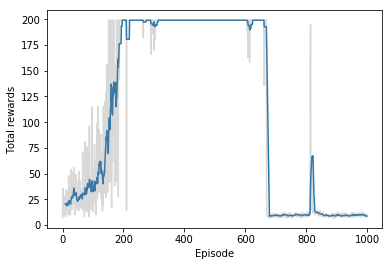

In [33]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

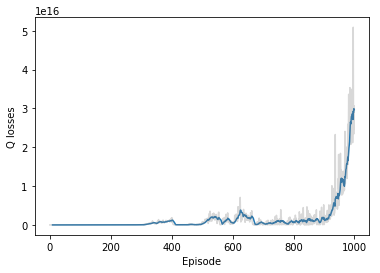

In [34]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

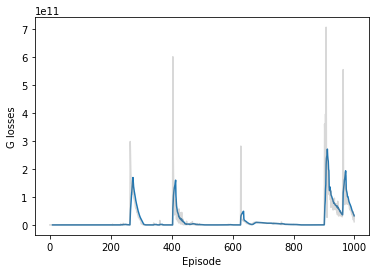

In [35]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

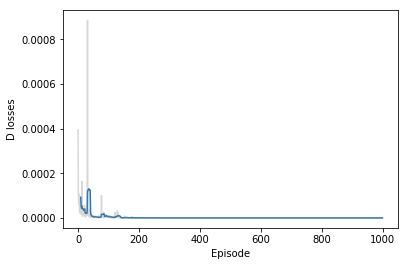

In [36]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [37]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [38]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.